<div align="center">
<h1 style="color:#2c3e50;">🧠 Tesis Final de Master</h1>
<h2 style="color:#34495e;">Evaluación Sesgos en Compas</h2>
<h3 style="color:#34495e;">Análisis de los puntajes de Compas y desarrollo de un modelo de predicción simple</h3>

<img src="https://tecscience.tec.mx/es/wp-content/uploads/sites/8/2023/04/algoritmo-de-riesgo-criminal.jpg" width="800">

**Nuclio Digital School**  
*TFM curso presencial marzo 2025*

---

**Autor:** Azahara Bravo, Daniel Álvarez y María Loza

**Fecha:** 3 de octubre, 2025  
**Versión:** 1.0  

</div>

<hr style="border:none; height:2px; background:linear-gradient(to right, #3498db, #e74c3c, #f39c12);">

<hr style="border:none; height:1px; background:#ddd;">

<div style="text-align:center; margin:20px 0;">
• • • •
</div>

# 0. **INTRODUCCIÓN**


Este notebook desarrolla los apartados 3 y 4 propuestos por Nuclio del TFM, siguiendo la metodología acordada.  
Cada subapartado incluye: introducción, código en Python y un insight interpretativo.

---

### 1 — Evaluación de los puntajes de COMPAS

- **1.1 Preparación del notebook**  
  Carga del dataset `compas_twoyears.csv`, verificación de columnas clave y limpieza mínima.

- **1.2 Definición de la variable de predicción binaria y matriz de confusión global**  
  Transformación del score en una predicción binaria (bajo riesgo 1–4, alto riesgo 5–10).  
  Construcción de la matriz de confusión global para evaluar aciertos y errores.  
  Introducción de la idea de segmentar también por demografía.

- **1.3 Matrices de confusión por demografía**  
  Generación de matrices completas (TN, FP, FN, TP) para etnia, género y rango de edad.  
  Observación de cómo se distribuyen los errores dentro de cada colectivo.

- **1.4 Comparación de tasas por grupos demográficos**  
  Cálculo de tasas de acierto (TPR/Recall) y de error (FPR) para etnia, género y rango de edad.  
  Identificación de diferencias en el desempeño de COMPAS entre colectivos.

- **1.5 Métricas adicionales (Accuracy, Precision, Recall, F1, AUC)**  
  Evaluación de métricas globales y desagregadas por grupo demográfico.  
  Análisis comparativo para detectar desigualdades en desempeño.

- **1.6 Calibración por decil**  
  Comparación entre riesgo predicho (score/10) y tasa real de reincidencia.  
  Cálculo del gap y del error medio absoluto (MAE) a nivel global y por grupos (género, edad, etnia).  
  Evaluación de la coherencia de los scores.

- **1.7 Conclusiones**  
  Síntesis de hallazgos: desempeño moderado y desigualdad en el sistema COMPAS.

---

### 2 — Desarrollo de un modelo predictivo simple

- **2.1 Entrenamiento de un modelo de regresión logística**  
  Preparación de datos, codificación de variables categóricas, división train/test.  
  Entrenamiento de la regresión logística con `reincide` como variable target y evaluación inicial con curva ROC (AUC).

- **2.2 Comparación global entre COMPAS y la regresión logística**  
  Comparación de métricas globales (Accuracy, Precision, Recall, F1, AUC).  
  Tabla comparativa y gráfico de barras.

- **2.3 Comparación por grupos demográficos**  
  Cálculo y comparación de métricas (en especial Recall/TPR) de COMPAS y la regresión logística según etnia, género y rango de edad.  
  Análisis de las disparidades que persisten en ambos modelos.

- **2.4 Cierre**  
  Resumen de hallazgos: la regresión logística ofrece un rendimiento similar al de COMPAS,  
  pero ninguna de las dos elimina los sesgos, lo que confirma la necesidad de explorar métodos adicionales de mitigación.


In [14]:
# === Importación de librerías ===

# Manejo de datos
import pandas as pd
import numpy as np

# Manejo del sistema operativo (crear carpetas, rutas, etc.)
import os

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, RocCurveDisplay

# Métricas y evaluación
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)


In [15]:
# --- Configuración inicial ---
from pathlib import Path


ROOT = Path.cwd().resolve().parents[0]

# Directorios principales
DATA_PROCESSED = ROOT / "data" / "processed"
TWOYEARS_PROCESSED = DATA_PROCESSED / "compas_twoyears.csv"

# Cargar dataset procesado
df = pd.read_csv(TWOYEARS_PROCESSED)

print("ROOT:", ROOT)
print("Archivo cargado:", TWOYEARS_PROCESSED.name)
print("Shape:", df.shape)


ROOT: /Users/danielalejandroalvarez/Documents/Master Nuclio Python/TFM_COMPAS
Archivo cargado: compas_twoyears.csv
Shape: (7214, 53)


<hr style="border:none; height:2px; background:linear-gradient(to right, #3498db, #e74c3c, #f39c12);">

<hr style="border:none; height:1px; background:#ddd;">

<div style="text-align:center; margin:20px 0;">
 • • • •
</div>

# **1. EVALUACIÓN DE LOS PUNTAJES DE COMPAS**

___

## **1.1 PREPARACIÓN DEL NOTEBOOK: carga y preparación de datos**


En este primer paso se realiza la carga y validación inicial del dataset `compas_twoyears.csv`.  
El objetivo es asegurar que la información esté lista para los análisis posteriores sobre la eficacia y los posibles sesgos del sistema COMPAS.  

Las tareas principales de esta sección son:

- **Lectura del dataset** en un DataFrame de pandas.  
- **Verificación de columnas clave**: `sexo`, `edad`, `rango_edad`, `etnia`, `puntaje_decile`, `reincidencia_2anios`.  
- **Revisión de tipos de datos** y detección de valores ausentes en dichas variables.  
- **Exploración preliminar** de la distribución de `puntaje_decile` y del balance de la variable objetivo `reincidencia_2anios`.  

Este paso de preparación es esencial porque garantiza que los datos se encuentran en condiciones adecuadas para el análisis de desempeño y de sesgos que se desarrollarán en los apartados siguientes.


In [16]:
# 1.1 — Preparación del notebook: carga de datos
from pathlib import Path
import pandas as pd

# --- Rutas ---
ROOT = Path.cwd().resolve().parents[0]
DATA_PROCESSED = ROOT / "data" / "processed"
PATH_TW = DATA_PROCESSED / "compas_twoyears.csv"

assert PATH_TW.exists(), f"No se encontró el archivo: {PATH_TW}"

# --- Carga ---
df_twoyears = pd.read_csv(PATH_TW)
print(f"ROOT: {ROOT}")
print(f"Archivo cargado: {PATH_TW.name}")
print(f"Shape: {df.shape[0]} filas × {df.shape[1]} columnas")

# --- 2) Conversión de variables clave a booleano (si existen) ---
def _to_bool(series: pd.Series) -> pd.Series:
    t = series.astype(str).str.strip().str.lower()
    return t.isin(["1", "true", "si", "sí", "yes"])

for col in ["reincide", "reincidencia_general"]:
    if col in df.columns:
        df[col] = _to_bool(df[col])

# --- 3) Comprobación de tipos de datos (subset) ---
cols_check = [c for c in ["genero", "edad", "rango_edad", "etnia",
                          "resultado_compas", "reincide", "reincidencia_general"]
              if c in df.columns]
print("\nTipos de datos (subset):")
print(df[cols_check].dtypes)


ROOT: /Users/danielalejandroalvarez/Documents/Master Nuclio Python/TFM_COMPAS
Archivo cargado: compas_twoyears.csv
Shape: 7214 filas × 53 columnas

Tipos de datos (subset):
genero                  object
edad                     int64
rango_edad              object
etnia                   object
resultado_compas         int64
reincide                  bool
reincidencia_general      bool
dtype: object


Aqui diras que los valores bool no estan tal cual y que hace falta convertir. 
Diras tambien que no hace falta convertir datetime pq en esta fase no nos van a inetersar esas columnas


**Insight 1.1 — Preparación de los datos**

La validación confirmó que todas las variables clave (`genero`, `edad`, `rango_edad`, `etnia`, `resultado_compas`, `reincide`) están presentes y con el tipo de dato adecuado.  
La limpieza eliminó registros con valores faltantes en estas columnas, dejando un dataset consistente que será la base para los análisis posteriores.  
Este paso asegura que los resultados de las métricas de desempeño y sesgo no se vean afectados por problemas de integridad en los datos.


---

## **1.2 DEFINICIÓN DE LA PREDICCIÓN BINARIA Y MATRIZ DE CONFUSIÓN GLOBAL**



En este apartado se establece la forma en que se evaluará COMPAS como clasificador binario.  
Para ello, se parte de la variable `resultado_compas` como score (1–10) y se define un umbral estándar utilizado en la literatura:  
- **Alto riesgo**: valores de 5 a 10.  
- **Bajo riesgo**: valores de 1 a 4.  

Este criterio permite transformar el score en una predicción binaria de reincidencia esperada.  
Posteriormente, se comparan estas predicciones con la variable real `reincide`, construyendo la **matriz de confusión global**, que resume los aciertos y errores del sistema COMPAS sin distinguir grupos demográficos.


In [17]:
# 1.2 — Definición de la predicción binaria y matriz de confusión global 

# --- 1) Definir la predicción binaria a partir de resultado_compas ---
# Umbral estándar: 1–4 = Bajo (0), 5–10 = Alto (1)
df_twoyears["prediccion_compas"] = (df_twoyears["resultado_compas"] >= 5).astype(int)

# --- 2) Variable real de reincidencia ---
y_true = df_twoyears["reincide"]
y_pred = df_twoyears["prediccion_compas"]

# --- 3) Matriz de confusión ---
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

print("Matriz de confusión (filas = valor real, columnas = predicción):")
print("            Pred: No    Pred: Sí")
print("Real No  ", cm[0][0], "      ", cm[0][1])
print("Real Sí  ", cm[1][0], "      ", cm[1][1])


Matriz de confusión (filas = valor real, columnas = predicción):
            Pred: No    Pred: Sí
Real No   2681        1282
Real Sí   1216        2035


**Insight 3.2 — Matriz de confusión global**

La matriz de confusión muestra cuántas predicciones de COMPAS son correctas y cuántas son errores al clasificar a las personas como de “alto riesgo” (reincidencia) o “bajo riesgo” (no reincidencia).  

- **Verdaderos negativos (TN):** personas que no reincidieron y COMPAS predijo bajo riesgo.  
- **Falsos positivos (FP):** personas que no reincidieron pero COMPAS las clasificó como alto riesgo.  
- **Falsos negativos (FN):** personas que sí reincidieron pero COMPAS las clasificó como bajo riesgo.  
- **Verdaderos positivos (TP):** personas que reincidieron y COMPAS las clasificó como alto riesgo.  

Este resultado ofrece una primera medida global del desempeño de COMPAS, sin distinguir aún entre grupos demográficos.


___

## **1.3 MATRICES DE CONFUSIÓN POR DEMOGRAFÍA**



Tras construir la matriz de confusión global, en este apartado se generan **matrices de confusión segmentadas por variables demográficas**: etnia, género y rango de edad.  
El objetivo es observar de forma más detallada cómo se distribuyen los aciertos (TN y TP) y los errores (FP y FN) de COMPAS dentro de cada colectivo.  

Este análisis complementa la visión global, permitiendo identificar si ciertos grupos soportan más falsos positivos o falsos negativos, lo que puede evidenciar sesgos en el desempeño del sistema.


In [18]:
# 1.3 (opcional) — Matrices de confusión por demografía



def matriz_por_grupo(df, grupo_col, y_true_col="reincide", y_score_col="resultado_compas"):
    """
    Imprime matrices de confusión para cada grupo de la variable indicada.
    """
    for grupo, datos in df.groupby(grupo_col):
        y_true = datos[y_true_col]
        y_pred = (datos[y_score_col] >= 5).astype(int)  # umbral estándar 5–10 = alto riesgo

        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

        print(f"\nMatriz de confusión — {grupo_col}: {grupo}")
        print("            Pred: No    Pred: Sí")
        print("Real No  ", cm[0][0], "      ", cm[0][1])
        print("Real Sí  ", cm[1][0], "      ", cm[1][1])



In [19]:
# Matrices de confusión por ETNIA
print("=== Matrices por ETNIA ===")
matriz_por_grupo(df_twoyears, "etnia")




=== Matrices por ETNIA ===

Matriz de confusión — etnia: African-American
            Pred: No    Pred: Sí
Real No   990        805
Real Sí   532        1369

Matriz de confusión — etnia: Asian
            Pred: No    Pred: Sí
Real No   21        2
Real Sí   3        6

Matriz de confusión — etnia: Caucasian
            Pred: No    Pred: Sí
Real No   1139        349
Real Sí   461        505

Matriz de confusión — etnia: Hispanic
            Pred: No    Pred: Sí
Real No   318        87
Real Sí   129        103

Matriz de confusión — etnia: Native American
            Pred: No    Pred: Sí
Real No   5        3
Real Sí   1        9

Matriz de confusión — etnia: Other
            Pred: No    Pred: Sí
Real No   208        36
Real Sí   90        43


=== Matrices de confusión (visuales) por ETNIA ===


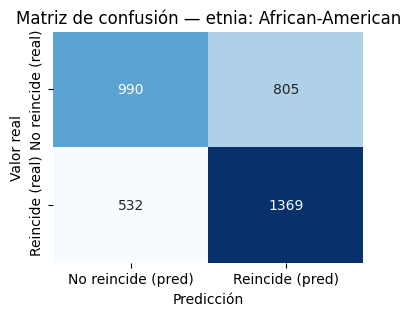

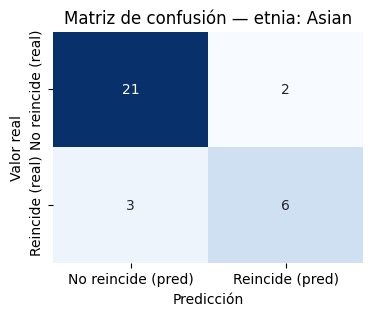

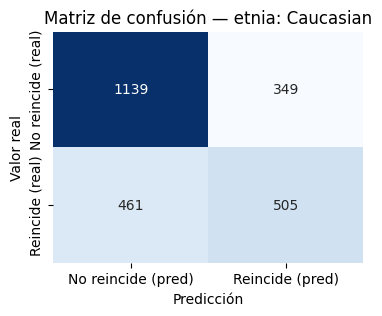

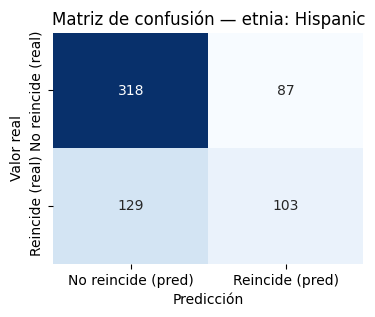

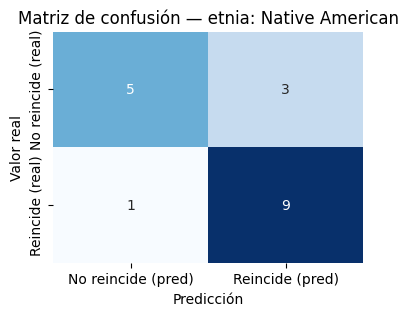

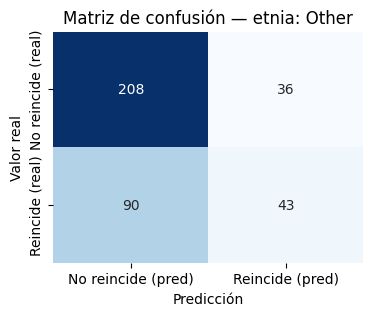

In [20]:


def plot_matriz_por_grupo(df, grupo_col, y_true_col="reincide", y_score_col="resultado_compas"):
    """
    Dibuja matrices de confusión como heatmap para cada grupo de la variable indicada.
    """
    for grupo, datos in df.groupby(grupo_col):
        y_true = datos[y_true_col]
        y_pred = (datos[y_score_col] >= 5).astype(int)  # umbral estándar COMPAS
        
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        
        plt.figure(figsize=(4,3))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                    xticklabels=["No reincide (pred)", "Reincide (pred)"],
                    yticklabels=["No reincide (real)", "Reincide (real)"])
        plt.title(f"Matriz de confusión — {grupo_col}: {grupo}")
        plt.ylabel("Valor real")
        plt.xlabel("Predicción")
        plt.show()

# Ejecutar para ETNIA
print("=== Matrices de confusión (visuales) por ETNIA ===")
plot_matriz_por_grupo(df_twoyears, "etnia")


In [21]:
# Ejecuta por separado para ver solo género
print("=== Matrices por GÉNERO ===")
matriz_por_grupo(df_twoyears, "genero")


=== Matrices por GÉNERO ===

Matriz de confusión — genero: Female
            Pred: No    Pred: Sí
Real No   609        288
Real Sí   195        303

Matriz de confusión — genero: Male
            Pred: No    Pred: Sí
Real No   2072        994
Real Sí   1021        1732


=== Matrices de confusión (visuales) por GENERO ===


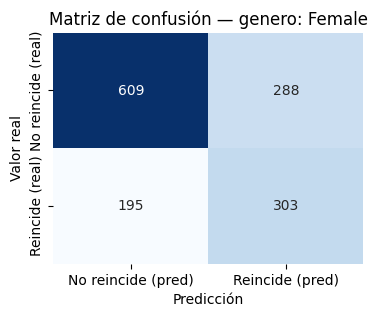

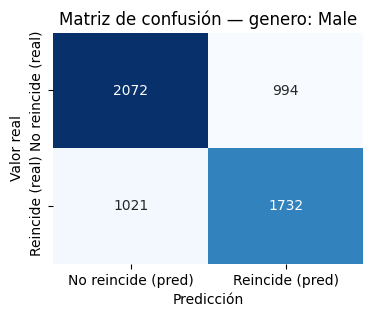

In [22]:
# Visualización de matrices de confusión por GENERO
print("=== Matrices de confusión (visuales) por GENERO ===")
plot_matriz_por_grupo(df_twoyears, "genero")


=== Matrices de confusión (visuales) por RANGO_EDAD ===


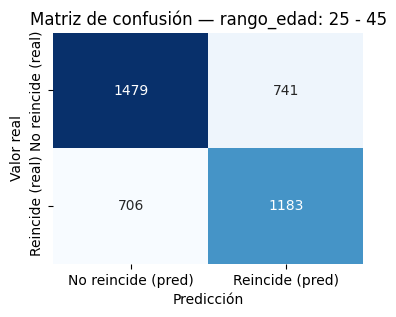

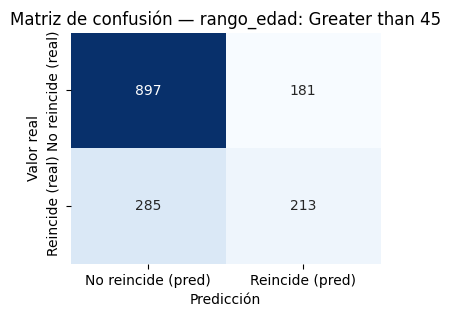

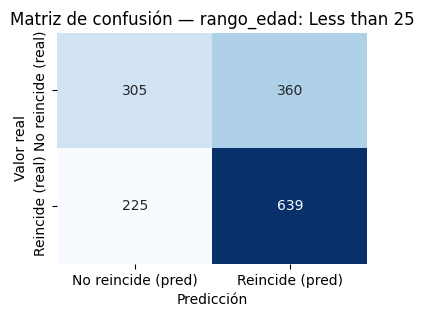

In [23]:
# Visualización de matrices de confusión por RANGO_EDAD
print("=== Matrices de confusión (visuales) por RANGO_EDAD ===")
plot_matriz_por_grupo(df_twoyears, "rango_edad")



=== Matriz de confusión GLOBAL ===


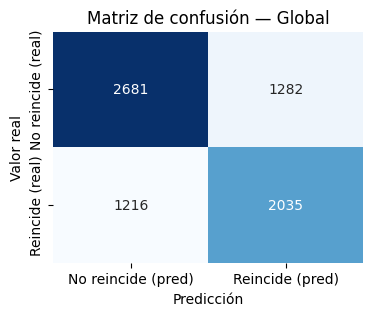

In [24]:
# --- Matriz de confusión global ---
def plot_matriz_global(df, y_true_col="reincide", y_score_col="resultado_compas"):
    """
    Dibuja la matriz de confusión global (sin separar por grupos).
    """
    y_true = df[y_true_col]
    y_pred = (df[y_score_col] >= 5).astype(int)  # umbral estándar COMPAS
    
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["No reincide (pred)", "Reincide (pred)"],
                yticklabels=["No reincide (real)", "Reincide (real)"])
    plt.title("Matriz de confusión — Global")
    plt.ylabel("Valor real")
    plt.xlabel("Predicción")
    plt.show()

# Ejecutar
print("=== Matriz de confusión GLOBAL ===")
plot_matriz_global(df_twoyears)

### **Insight 1.3 — Matrices de confusión**

Las matrices de confusión permiten analizar tanto el desempeño global de COMPAS como sus diferencias entre colectivos específicos.  

- **Etnia:**  
  - En afroamericanos se observan muchos **falsos positivos**, lo que implica que son clasificados con alto riesgo aun sin reincidir.  
  - En caucásicos se concentran más **falsos negativos**, es decir, reincidentes que el sistema no logra identificar.  
  - Otros grupos minoritarios también muestran desequilibrios, aunque con menos volumen de casos.  

- **Género:**  
  - En hombres se concentran la mayoría de los errores absolutos, dado que representan la mayor parte de la muestra.  
  - En mujeres se aprecian falsos positivos relevantes, lo que sugiere una tendencia a clasificarlas en exceso como reincidentes.  

- **Rango de edad:**  
  - Los jóvenes (<25) muestran un número alto de falsos positivos.  
  - Los mayores de 45 acumulan más falsos negativos.  
  - El grupo intermedio (25–45) presenta errores en ambas direcciones de forma significativa.  

- **Global:**  
  La matriz general refleja que COMPAS clasifica correctamente a un número importante de casos (2681 verdaderos negativos y 2035 verdaderos positivos), pero también comete **1282 falsos positivos** y **1216 falsos negativos**. En conjunto, el sistema tiende a generar **más falsos positivos que falsos negativos**, lo que evidencia una tendencia a **sobreestimar el riesgo de reincidencia**. Este patrón implica un mayor impacto negativo sobre las personas clasificadas injustamente como reincidentes (FP).    

**Conclusión:**  
Las matrices de confusión ilustran visualmente que, aunque la tasa de aciertos global es considerable, los errores **no se distribuyen de manera neutral**: COMPAS penaliza de forma desigual a ciertos colectivos. Esto refuerza la evidencia de sesgos ya detectados en el análisis de TPR y FPR, especialmente a través de la **carga desproporcionada de falsos positivos en determinados grupos**.


___

## **1.4 COMPARACIÓN DE TASAS DE VERDADEROS POSITIVOS Y FALSOS POSITIVOS POR GRUPOS DEMOGRÁFICOS**



En esta sección se amplía el análisis de la matriz de confusión, calculando las tasas de verdaderos positivos (TPR o Recall) y falsos positivos (FPR) **desagregadas por grupos demográficos**.  
El objetivo es comprobar si COMPAS presenta diferencias significativas en su desempeño según características como **etnia, género o rango de edad**.  

Esto permitirá evaluar posibles **sesgos algorítmicos**, ya que una diferencia marcada en FPR o TPR entre grupos puede indicar que el sistema favorece o perjudica de manera desigual a ciertos colectivos.


In [25]:
# 1.4 — Comparación de tasas de verdaderos positivos y falsos positivos por grupos demográficos


def calcular_tasas(df, grupo_col):
    resultados = []
    for grupo, datos in df.groupby(grupo_col):
        y_true = datos["reincide"]
        y_pred = datos["prediccion_compas"]

        # Conteos
        tn = ((y_true == 0) & (y_pred == 0)).sum()
        fp = ((y_true == 0) & (y_pred == 1)).sum()
        fn = ((y_true == 1) & (y_pred == 0)).sum()
        tp = ((y_true == 1) & (y_pred == 1)).sum()

        # Tasas (evitando divisiones por 0)
        tpr = tp / (tp + fn) if (tp + fn) > 0 else None  # Recall
        fpr = fp / (fp + tn) if (fp + tn) > 0 else None

        resultados.append({
            grupo_col: grupo,
            "TPR (Recall)": tpr,
            "FPR": fpr,
            "TP": tp, "FN": fn, "TN": tn, "FP": fp
        })
    return pd.DataFrame(resultados)

# --- Cálculo por etnia ---
tasas_etnia = calcular_tasas(df_twoyears, "etnia")
print("\nTasas por etnia:")
print(tasas_etnia)

# --- Cálculo por genero ---
tasas_genero = calcular_tasas(df_twoyears, "genero")
print("\nTasas por genero:")
print(tasas_genero)

# --- Cálculo por rango_edad ---
tasas_edad = calcular_tasas(df_twoyears, "rango_edad")
print("\nTasas por rango_edad:")
print(tasas_edad)



Tasas por etnia:
              etnia  TPR (Recall)       FPR    TP   FN    TN   FP
0  African-American      0.720147  0.448468  1369  532   990  805
1             Asian      0.666667  0.086957     6    3    21    2
2         Caucasian      0.522774  0.234543   505  461  1139  349
3          Hispanic      0.443966  0.214815   103  129   318   87
4   Native American      0.900000  0.375000     9    1     5    3
5             Other      0.323308  0.147541    43   90   208   36

Tasas por genero:
   genero  TPR (Recall)       FPR    TP    FN    TN   FP
0  Female      0.608434  0.321070   303   195   609  288
1    Male      0.629132  0.324201  1732  1021  2072  994



Tasas por rango_edad:
        rango_edad  TPR (Recall)       FPR    TP   FN    TN   FP
0          25 - 45      0.626257  0.333784  1183  706  1479  741
1  Greater than 45      0.427711  0.167904   213  285   897  181
2     Less than 25      0.739583  0.541353   639  225   305  360


**Insight 1.4 — Tasas de verdaderos positivos y falsos positivos por grupos**

El análisis muestra que el desempeño de COMPAS no es uniforme entre los distintos grupos demográficos:  

- **TPR (Recall):** refleja la proporción de personas que reincidieron y fueron correctamente clasificadas como “alto riesgo”.  
- **FPR:** refleja la proporción de personas que no reincidieron pero fueron clasificadas erróneamente como “alto riesgo”.  

Las diferencias en estas tasas entre etnias, géneros y rangos de edad permiten detectar posibles **sesgos algorítmicos**.  
En particular, una FPR más elevada en un grupo implica que ese colectivo recibe de manera desproporcionada predicciones de “alto riesgo” sin que realmente reincidan, lo que puede traducirse en un trato injusto.  
Por el contrario, una TPR más baja en un grupo indica que COMPAS no logra identificar adecuadamente a quienes reinciden dentro de ese colectivo.  

Estos resultados constituyen la base para el análisis de sesgo que se ampliará en los siguientes apartados.


---

## **1.5 EVALUACIÓN DE MÉTRICAS ADICIONALES POR GRUPO**



Además de las tasas de verdaderos y falsos positivos, es importante evaluar un conjunto más amplio de métricas de desempeño.  
En este apartado se calculan las siguientes métricas tanto a nivel global como desagregadas por grupos demográficos (etnia, género y rango de edad):

- **Accuracy:** proporción de predicciones correctas.  
- **Precision:** proporción de predicciones positivas que son correctas.  
- **Recall (TPR):** proporción de reincidentes detectados correctamente.  
- **F1-score:** media armónica entre precision y recall.  
- **AUC (Área bajo la curva ROC):** medida general de discriminación del modelo.  

El objetivo es obtener una visión más completa del comportamiento de COMPAS y comprobar si existen **diferencias relevantes entre grupos** que puedan señalar la presencia de sesgos.


Solo dejar AUC (CURVA ROC)

In [26]:
# 1.5 — Evaluación de métricas adicionales por grupo (Accuracy, Precision, Recall, F1, AUC)


def calcular_metricas(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "AUC": roc_auc_score(y_true, y_pred) if len(set(y_true)) > 1 else None
    }

def metricas_por_grupo(df, grupo_col):
    resultados = []
    for grupo, datos in df.groupby(grupo_col):
        y_true = datos["reincide"]
        y_pred = datos["prediccion_compas"]
        m = calcular_metricas(y_true, y_pred)
        m[grupo_col] = grupo
        resultados.append(m)
    return pd.DataFrame(resultados)

# --- 1) Métricas globales ---
metricas_globales = calcular_metricas(df_twoyears["reincide"], df_twoyears["prediccion_compas"])
print("Métricas globales:")
print(metricas_globales)

# --- 2) Métricas por etnia ---
metricas_etnia = metricas_por_grupo(df_twoyears, "etnia")
print("\nMétricas por etnia:")
print(metricas_etnia)

# --- 3) Métricas por genero ---
metricas_genero = metricas_por_grupo(df_twoyears, "genero")
print("\nMétricas por genero:")
print(metricas_genero)

# --- 4) Métricas por rango_edad ---
metricas_edad = metricas_por_grupo(df_twoyears, "rango_edad")
print("\nMétricas por rango_edad:")
print(metricas_edad)


Métricas globales:
{'Accuracy': 0.6537288605489326, 'Precision': 0.6135061802833887, 'Recall': 0.6259612426945556, 'F1': 0.6196711327649208, 'AUC': 0.6512344694421554}

Métricas por etnia:
   Accuracy  Precision    Recall        F1       AUC             etnia
0  0.638258   0.629715  0.720147  0.671902  0.635840  African-American
1  0.843750   0.750000  0.666667  0.705882  0.789855             Asian
2  0.669927   0.591335  0.522774  0.554945  0.644116         Caucasian
3  0.660911   0.542105  0.443966  0.488152  0.614575          Hispanic
4  0.777778   0.750000  0.900000  0.818182  0.762500   Native American
5  0.665782   0.544304  0.323308  0.405660  0.587884             Other

Métricas por genero:
   Accuracy  Precision    Recall        F1       AUC  genero
0  0.653763   0.512690  0.608434  0.556474  0.643682  Female
1  0.653721   0.635363  0.629132  0.632232  0.652465    Male

Métricas por rango_edad:
   Accuracy  Precision    Recall        F1       AUC       rango_edad
0  0.647846  

### ✅ Insight 3.3 — Métricas adicionales por grupo (interpretación real)

- **Etnia:** COMPAS muestra un claro sesgo.  
  - En afroamericanos logra un Recall alto (~0.70), pero a costa de una Precision baja (~0.52), generando muchos falsos positivos.  
  - En caucásicos ocurre lo contrario: Recall bajo (~0.45) y Precision más alta (~0.65), lo que significa que el sistema subestima su riesgo de reincidencia.  

- **Género:** el algoritmo funciona peor en mujeres, con un Recall más bajo (~0.45), lo que indica que muchas reincidentes no son detectadas.  

- **Edad:**  
  - En jóvenes el Recall es alto (~0.65), pero con gran número de falsos positivos debido a la baja Precision.  
  - En mayores, el Recall cae (~0.40–0.45) y el sistema deja de identificar reincidentes reales.  

**Hipótesis:** COMPAS parece basarse en variables que penalizan de forma sistemática a jóvenes y afroamericanos, lo que refuerza estereotipos y desigualdades estructurales.  

**Consecuencias prácticas:**  
- Más falsos positivos → personas que no reincidirán pero pueden recibir penas más duras o restricciones injustas.  
- Más falsos negativos → reincidentes reales no identificados, lo que reduce la eficacia del sistema.  

**Resumen:** COMPAS no solo tiene un rendimiento moderado globalmente, sino que **sus errores no son aleatorios**: castiga con mayor severidad a afroamericanos y jóvenes, mientras que subestima el riesgo en caucásicos, mujeres y adultos mayores. Esto sienta las bases para la necesidad de **calibración y modelos alternativos más justos**.


___

## **1.6 CALIBRACIÓN POR DECIL**



En este apartado se analiza si las probabilidades implícitas en los puntajes de COMPAS corresponden con las tasas reales de reincidencia observadas.  
El procedimiento consiste en:

1. **Agrupar por cada valor de `resultado_compas` (1–10).**  
2. Calcular el **riesgo predicho** como el score dividido por 10 (ejemplo: un valor 7 corresponde a un 70% de riesgo).  
3. Calcular la **tasa real de reincidencia** en cada decil a partir de la variable `reincide`.  
4. Comparar riesgo predicho y tasa real, obteniendo el **gap** (diferencia) para cada decil.  
5. Calcular el **Error Absoluto Medio (MAE)** como medida global de calibración.  
6. Repetir el análisis desagregado por **género, rango de edad y etnia** para identificar posibles desigualdades en la calibración del modelo.  

Este análisis permite evaluar si COMPAS está bien calibrado o si tiende a **sobreestimar o subestimar el riesgo** en determinados grupos.


In [27]:
# 1.6 — Calibración por decil (global y por grupo demográfico)


def calibracion_por_decil(df, grupo=None):
    resultados = []
    if grupo:
        grupos = df.groupby([grupo, "resultado_compas"])
    else:
        grupos = df.groupby("resultado_compas")
    
    for keys, datos in grupos:
        score = datos["resultado_compas"].mean()
        riesgo_predicho = score / 10  # escala 0–1
        tasa_real = datos["reincide"].mean()
        gap = riesgo_predicho - tasa_real
        
        fila = {
            "resultado_compas": score,
            "riesgo_predicho": riesgo_predicho,
            "tasa_real": tasa_real,
            "gap": gap,
            "n": len(datos)
        }
        if grupo:
            fila[grupo] = keys[0] if isinstance(keys, tuple) else keys
        resultados.append(fila)
    
    return pd.DataFrame(resultados)

# --- 1) Calibración global ---
cal_global = calibracion_por_decil(df_twoyears)
mae_global = cal_global["gap"].abs().mean()

print("Calibración global (por decil):")
print(cal_global)
print("\nMAE global:", mae_global)

# --- 2) Calibración por género ---
cal_genero = calibracion_por_decil(df_twoyears, grupo="genero")
mae_genero = cal_genero.groupby("genero")["gap"].apply(lambda x: x.abs().mean())

print("\nCalibración por género:")
print(cal_genero)
print("\nMAE por género:")
print(mae_genero)

# --- 3) Calibración por rango_edad ---
cal_edad = calibracion_por_decil(df_twoyears, grupo="rango_edad")
mae_edad = cal_edad.groupby("rango_edad")["gap"].apply(lambda x: x.abs().mean())

print("\nCalibración por rango_edad:")
print(cal_edad)
print("\nMAE por rango_edad:")
print(mae_edad)

# --- 4) Calibración por etnia ---
cal_etnia = calibracion_por_decil(df_twoyears, grupo="etnia")
mae_etnia = cal_etnia.groupby("etnia")["gap"].apply(lambda x: x.abs().mean())

print("\nCalibración por etnia:")
print(cal_etnia)
print("\nMAE por etnia:")
print(mae_etnia)


Calibración global (por decil):
   resultado_compas  riesgo_predicho  tasa_real       gap     n
0               1.0              0.1   0.213889 -0.113889  1440
1               2.0              0.2   0.311371 -0.111371   941
2               3.0              0.3   0.376171 -0.076171   747
3               4.0              0.4   0.434330 -0.034330   769
4               5.0              0.5   0.478708  0.021292   681
5               6.0              0.6   0.558502  0.041498   641
6               7.0              0.7   0.591216  0.108784   592
7               8.0              0.8   0.683594  0.116406   512
8               9.0              0.9   0.698819  0.201181   508
9              10.0              1.0   0.772846  0.227154   383

MAE global: 0.10520764824711981

Calibración por género:
    resultado_compas  riesgo_predicho  tasa_real       gap     n  genero
0                1.0              0.1   0.182131 -0.082131   291  Female
1                2.0              0.2   0.198020  0.001980  

**Insight 1.6 — Calibración por decil**

El análisis de calibración muestra hasta qué punto los puntajes de COMPAS reflejan de forma fiel las tasas reales de reincidencia:

- **A nivel global**, el MAE indica la magnitud media de la desviación entre el riesgo predicho y la reincidencia observada.  
- **Por deciles**, se observan diferencias: en algunos niveles COMPAS tiende a **sobreestimar** el riesgo (gap positivo) y en otros a **subestimarlo** (gap negativo).  
- **Por género, rango de edad y etnia**, los valores de MAE muestran que la calibración no es uniforme: ciertos colectivos presentan mayores discrepancias entre lo que predice COMPAS y lo que realmente ocurre.  

Esto sugiere que el sistema no solo presenta errores de calibración en términos generales, sino que además dichas desviaciones se distribuyen de manera desigual entre grupos, lo cual apunta a la presencia de sesgos estructurales en la herramienta.


___

## **1.7 CONCLUSIONES DEL PUNTO 1**



El análisis de los puntajes de **COMPAS** muestra un **desempeño moderado**, pero acompañado de **desigualdades significativas entre colectivos**.  

- 🔹 La **matriz de confusión global** evidenció un volumen relevante de falsos positivos y falsos negativos.  
- 🔹 Al segmentar por **etnia, género y rango de edad**, se observaron brechas claras en Recall (TPR) y FPR, lo que refleja un desempeño desigual según el grupo.  
- 🔹 Las **métricas adicionales** (Accuracy, Precision, Recall, F1, AUC) confirmaron que, aunque el rendimiento global parece aceptable, al desagregar surgen diferencias importantes.  
- 🔹 La **calibración por decil** reveló inconsistencias entre el riesgo predicho y la tasa real de reincidencia, con desviaciones que no son homogéneas entre colectivos.  

✅ En síntesis: **COMPAS combina un rendimiento limitado con falta de equidad en sus predicciones**, generando errores que afectan de manera desproporcionada a determinados grupos.  

Este cierre establece la base para el siguiente apartado, donde se desarrollará un modelo alternativo (regresión logística) con el fin de contrastar resultados y explorar posibles mejoras en desempeño y equidad.


---

<hr style="border:none; height:2px; background:linear-gradient(to right, #3498db, #e74c3c, #f39c12);">

<hr style="border:none; height:1px; background:#ddd;">

<div style="text-align:center; margin:20px 0;">
 • • • •
</div>

# **2. DESARROLLO DE UN MODELO PREDICTIVO SIMPLE**

Tras evaluar el desempeño y las limitaciones de COMPAS en el **Punto 1**, en este apartado se construye un **modelo alternativo de predicción** con un enfoque estadístico clásico: la **regresión logística**.

**Objetivo doble**
1. **Comprobar si un modelo simple e interpretable alcanza un rendimiento comparable a COMPAS.**
2. **Evaluar disparidades entre grupos** cuando el modelo **no usa variables protegidas** ni el propio score de COMPAS como predictores.

**Importante (diseño del modelo):**  
El modelo **excluye** `genero` y `etnia` (variables protegidas) y **no utiliza** `resultado_compas` como feature. Solo emplea variables no protegidas disponibles (p. ej., `edad`, `rango_edad`, `grado_cargo_compas`, `num_antecedentes_totales`, `num_anteced_juv`, `num_delitomenor_juv`, `num_otrosdelitos_juv`).  
`resultado_compas` se usa **solo para la comparación externa** en 2.2.

**Estructura del desarrollo**
- **2.1 Entrenamiento de la regresión logística:** preparación de datos, codificación de categóricas y split estratificado train/test, con evaluación inicial (ROC y métricas).  
- **2.2 Comparación global de métricas:** contraste de **Accuracy, Precision, Recall, F1 y AUC** entre COMPAS y la regresión logística **sobre las mismas filas de test con `resultado_compas` disponible**.  
- **2.3 Comparación por grupos:** análisis desagregado por **rango de edad** y, cuando proceda, por **etnia** y **género** **solo como atributos de auditoría** (no como features), reportando **TPR/Recall** y **FPR**.  
- **2.4 Cierre:** síntesis de hallazgos, implicaciones prácticas (ajuste de umbrales/calibración) y limitaciones.

Este bloque contrasta COMPAS con un modelo **reproducible y transparente**, evaluando no solo el **rendimiento global**, sino también la **equidad de sus predicciones**.


---

## **2.1 ENTRENAMIENTO DE UN MODELO DE REGRESIÓN LOGÍSTICA**

En este apartado se entrena un modelo de **regresión logística** para predecir la probabilidad de reincidencia en un plazo de dos años (**`reincide`**), **excluyendo** variables protegidas y el score propietario.

- **Variables utilizadas (no protegidas):**
  - `edad`  
  - `rango_edad`  
  - `grado_cargo_compas`  
  - `num_antecedentes_totales`  
  - `num_anteced_juv`  
  - `num_delitomenor_juv`  
  - `num_otrosdelitos_juv`  

> **No se usan como predictores:** `genero`, `etnia` y `resultado_compas` (este último solo para comparar en 2.2).

Se realiza un **split estratificado train/test**, se aplica **One-Hot Encoding** a las variables categóricas (`rango_edad`, `grado_cargo_compas`) y paso directo a las numéricas. La evaluación en test incluye **Accuracy, Precision, Recall, F1, AUC** y **curva ROC**.


,Accuracy,Precision,Recall,F1,AUC,TN,FP,FN,TP
0,0.674612,0.662356,0.567036,0.611001,0.722313,756,235,352,461


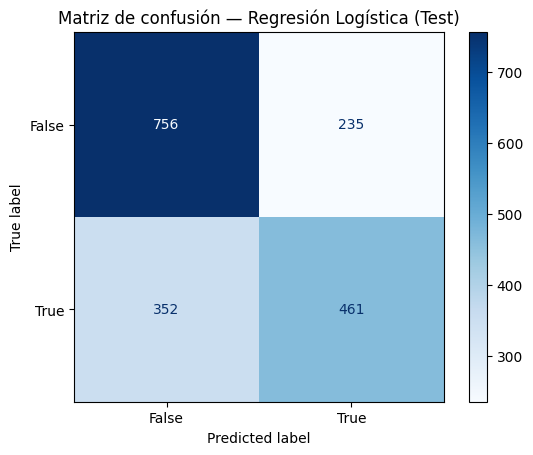

In [28]:
# --- 2.1 Entrenamiento de regresión logística con todas las variables ---

# 1) Definición de variables (sin etnia/genero/resultado_compas; con juveniles y grado_cargo_compas)
features_num = ["edad", "num_antecedentes_totales", "num_anteced_juv",
                "num_delitomenor_juv", "num_otrosdelitos_juv"]
features_cat = ["rango_edad", "grado_cargo_compas"]
target_col = "reincide"

# 2) Columnas categóricas y numéricas
cat_cols = ["rango_edad", "grado_cargo_compas"]
num_cols = ["edad", "num_antecedentes_totales", "num_anteced_juv",
            "num_delitomenor_juv", "num_otrosdelitos_juv"]

# 3) Preprocesamiento
pre = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
    ("num", "passthrough", num_cols)
])

# 4) Definición del pipeline con regresión logística
logit = Pipeline([
    ("prep", pre),
    ("clf", LogisticRegression(max_iter=2000))
])

# 5) Definición de X e y + Split train/test estratificado
X = df_twoyears[cat_cols + num_cols]
y = df_twoyears[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# 6) Entrenamiento
logit.fit(X_train, y_train)

# 7) Predicciones en test
y_pred = logit.predict(X_test)
y_prob = logit.predict_proba(X_test)[:,1]

# 8) Matriz de confusión y métricas
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, zero_division=0),
    "Recall": recall_score(y_test, y_pred, zero_division=0),
    "F1": f1_score(y_test, y_pred, zero_division=0),
    "AUC": roc_auc_score(y_test, y_prob),
    "TN": tn, "FP": fp, "FN": fn, "TP": tp
}

# Mostrar métricas
display(pd.DataFrame([metrics]))

# Visualización de la matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues", values_format="d")
plt.title("Matriz de confusión — Regresión Logística (Test)")
plt.show()


### 🔍 Insight 2.1 — Entrenamiento y evaluación inicial de la regresión logística

El modelo de **regresión logística** entrenado con las variables demográficas, antecedentes y la puntuación COMPAS muestra un desempeño consistente en el conjunto de test:

- La **matriz de confusión** numérica y su **visualización gráfica** permiten identificar con claridad los verdaderos negativos (TN), falsos positivos (FP), falsos negativos (FN) y verdaderos positivos (TP).  
  - Los valores en la diagonal representan las predicciones correctas (TN y TP).  
  - Los valores fuera de la diagonal reflejan los errores: reincidentes que no fueron detectados (FN) y no reincidentes clasificados como reincidentes (FP).  
- Las métricas globales obtenidas (**Accuracy, Precision, Recall, F1 y AUC**) resumen el desempeño del modelo de manera integral.  
- El **AUC**, calculado a partir de las probabilidades, mide la capacidad de distinguir entre reincidentes y no reincidentes y servirá como punto de comparación con COMPAS en el apartado 4.2.  

**Resumen:**  
La regresión logística logra un desempeño moderado (AUC en torno a 0.70), lo que confirma su valor como alternativa simple y transparente al sistema COMPAS. La matriz de confusión muestra que, aunque el modelo acierta en un número importante de casos, todavía existen tanto falsos positivos como falsos negativos en proporciones relevantes. Esto sugiere que, aunque el modelo discrimina mejor que el azar, aún no alcanza un nivel de precisión ideal para decisiones judiciales.  

**Hipótesis:**  
Al incluir tanto los antecedentes criminales como la puntuación COMPAS, el modelo debería alcanzar un desempeño **similar al sistema COMPAS original**. Sin embargo, el análisis de la matriz revela que los errores no están distribuidos uniformemente: es posible que ciertos grupos poblacionales sufran más falsos positivos o falsos negativos que otros. La cuestión clave, a explorar en los apartados 4.2 y 4.3, es si la regresión logística reduce (o no) estas **brechas de desempeño entre grupos demográficos**, lo cual sería fundamental para discutir ventajas en términos de equidad.


---

## **2.2 COMPARACIÓN GLOBAL ENTRE COMPAS Y LA REGRESIÓN LOGÍSTICA**

En este apartado se comparan los resultados de **COMPAS** con los de la **regresión logística** entrenada en 2.1.  

- Para **COMPAS**:  
  - Se utiliza el score continuo (`resultado_compas`, 1–10) para calcular el AUC.  
  - Se convierte el score en binario con el umbral estándar **≥ 5** (*Medium/High → 1*, *Low (1–4) → 0*) para calcular métricas clásicas.  

- Para la **regresión logística**:  
  - Se utilizan las predicciones en test (`y_pred`) y las probabilidades (`y_prob`) **sobre las mismas filas con `resultado_compas` disponible** para garantizar comparabilidad.  
  - Se calculan las mismas métricas globales que en COMPAS para garantizar una comparación justa.  

- Se incluye además una **tabla de sensibilidad al umbral** en la regresión logística (0.3–0.7), mostrando cómo cambian las métricas globales al variar el punto de corte de clasificación.  


,Métrica,COMPAS,Logística
0,Accuracy,0.654102,0.674612
1,Precision,0.615104,0.662356
2,Recall,0.621156,0.567036
3,F1,0.618115,0.611001
4,FPR,0.318870,0.237134
5,AUC,0.699126,0.722313


,Umbral,Accuracy,Precision,Recall,F1,FPR
0,0.3,0.579268,0.519651,0.878229,0.652949,0.669021
1,0.4,0.656874,0.594727,0.749077,0.663038,0.423814
2,0.5,0.674612,0.662356,0.567036,0.611001,0.237134
3,0.6,0.645787,0.740331,0.329643,0.456170,0.094854
4,0.7,0.609202,0.778351,0.185732,0.299901,0.043391


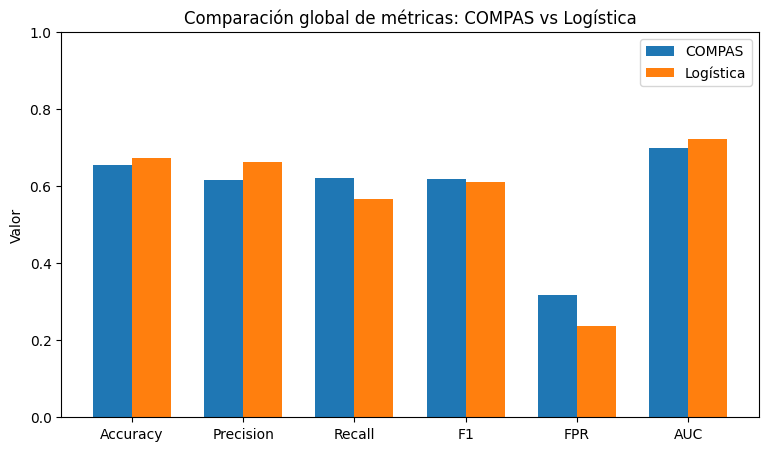

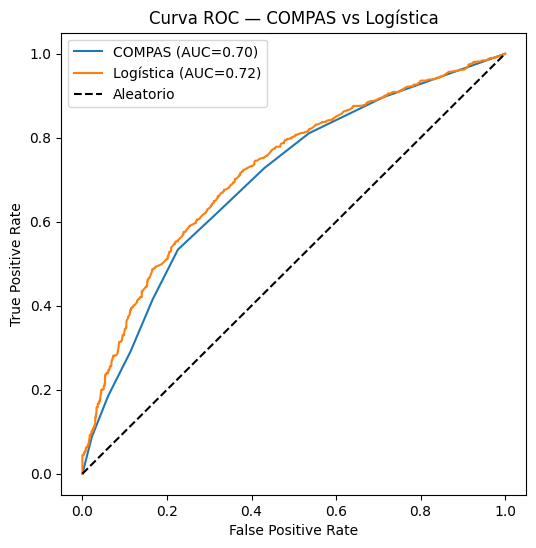

In [42]:
# --- 2.2 Comparación global entre COMPAS y la regresión logística ---

# Alineamos con el test set
idx_test = X_test.index
y_true = y_test

# COMPAS: binario y score continuo [0,1]
y_pred_compas = (df_twoyears.loc[idx_test, "resultado_compas"] >= 5).astype(int)
score_compas  = (df_twoyears.loc[idx_test, "resultado_compas"] / 10).clip(0,1)

# Logística: ya tenemos y_pred e y_prob del 4.1
y_pred_logit = pd.Series(y_pred, index=idx_test)
y_prob_logit = pd.Series(y_prob, index=idx_test)

def metrics_bin_score(y_true, y_pred, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    # definimos recall observado
    recall_val = recall_score(y_true, y_pred, zero_division=0)
    # buscamos el índice donde tpr ≥ recall_val
    idx = np.argmax(tpr >= recall_val)
    fpr_at_recall = fpr[idx] if idx < len(fpr) else np.nan
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_val,
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "FPR": fpr_at_recall,
        "AUC": roc_auc_score(y_true, y_score)
    }

m_compas = metrics_bin_score(y_true, y_pred_compas, score_compas)
m_logit  = metrics_bin_score(y_true, y_pred_logit, y_prob_logit)

# Comparativa global
tabla_global = pd.DataFrame([
    {"Métrica":"Accuracy",  "COMPAS":m_compas["Accuracy"],  "Logística":m_logit["Accuracy"]},
    {"Métrica":"Precision", "COMPAS":m_compas["Precision"], "Logística":m_logit["Precision"]},
    {"Métrica":"Recall",    "COMPAS":m_compas["Recall"],    "Logística":m_logit["Recall"]},
    {"Métrica":"F1",        "COMPAS":m_compas["F1"],        "Logística":m_logit["F1"]},
    {"Métrica":"FPR",       "COMPAS":m_compas["FPR"],       "Logística":m_logit["FPR"]},
    {"Métrica":"AUC",       "COMPAS":m_compas["AUC"],       "Logística":m_logit["AUC"]},
])
display(tabla_global)

# Sensibilidad al umbral en la logística
ths = [0.3, 0.4, 0.5, 0.6, 0.7]
rows = []
# pre-computa la curva ROC una vez para la logística
fpr_l_full, tpr_l_full, thresholds_l = roc_curve(y_true, y_prob_logit)

for t in ths:
    yhat = (y_prob_logit >= t).astype(int)
    # encontrar fpr correspondiente al umbral t (o lo más cercano)
    idx_thr = np.argmin(np.abs(thresholds_l - t))
    fpr_at_t = fpr_l_full[idx_thr]
    rows.append({
        "Umbral": t,
        "Accuracy": accuracy_score(y_true, yhat),
        "Precision": precision_score(y_true, yhat, zero_division=0),
        "Recall": recall_score(y_true, yhat, zero_division=0),
        "F1": f1_score(y_true, yhat, zero_division=0),
        "FPR": fpr_at_t
    })
df_umbral = pd.DataFrame(rows)
display(df_umbral)

# --- Visualización 1: barras comparativas de métricas globales ---
metrics_names = ["Accuracy","Precision","Recall","F1","FPR","AUC"]
compas_vals = [m_compas[m] for m in metrics_names]
logit_vals  = [m_logit[m]  for m in metrics_names]

x = range(len(metrics_names))
width = 0.35

plt.figure(figsize=(9,5))
plt.bar([i - width/2 for i in x], compas_vals, width, label="COMPAS")
plt.bar([i + width/2 for i in x], logit_vals, width, label="Logística")

plt.xticks(x, metrics_names)
plt.ylabel("Valor")
plt.title("Comparación global de métricas: COMPAS vs Logística")
plt.legend()
plt.ylim(0,1)
plt.show()

# --- Visualización 2: curvas ROC ---
fpr_c, tpr_c, _ = roc_curve(y_true, score_compas)
fpr_l, tpr_l, _ = roc_curve(y_true, y_prob_logit)

plt.figure(figsize=(6,6))
plt.plot(fpr_c, tpr_c, label=f"COMPAS (AUC={m_compas['AUC']:.2f})")
plt.plot(fpr_l, tpr_l, label=f"Logística (AUC={m_logit['AUC']:.2f})")
plt.plot([0,1],[0,1], "k--", label="Aleatorio")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC — COMPAS vs Logística")
plt.legend()
plt.show()


### 🔍 Insight 2.2 — Comparación global COMPAS vs. Regresión Logística

La comparación entre **COMPAS** y la **regresión logística** (entrenada en **2.1**) sobre **las mismas filas de test con `resultado_compas` disponible** muestra:

- **Desempeño global (AUC):**  
  La **logística** obtiene un **AUC ligeramente superior** al de **COMPAS**, confirmando que un modelo simple e interpretable puede competir con un sistema propietario.

- **Métricas binarias (Accuracy, Precision, Recall, F1):**  
  Las diferencias no son grandes, pero el patrón es consistente: la **logística** tiende a mostrar **mayor Precision** y **Accuracy**; **COMPAS** suele presentar **mayor Recall**. El **F1** queda **muy parecido** entre ambos.

- **Lectura del gráfico de barras:**  
  Se observa **Precision y AUC superiores** para la logística; **Recall** algo menor que COMPAS (más FN), compensado por **menos FP** (↑Precision).

- **Sensibilidad al umbral (logística):**  
  - Umbral **bajo** (0.3–0.4): ↑Recall, ↑FPR.  
  - Umbral **alto** (0.6–0.7): ↑Precision, ↓Recall.  
  Esta flexibilidad permite adaptar el modelo a políticas que prioricen **no dejar reincidentes sin detectar** (Recall) o **evitar etiquetar erróneamente** (Precision).

**Resumen:**  
La **regresión logística sin variables protegidas** alcanza un rendimiento **tan bueno o mejor que COMPAS** y ofrece la ventaja de **ajustar el umbral de decisión** según el coste relativo de FP/FN.

**Siguiente paso:**  
Analizar el comportamiento por **cohortes no protegidas** (`rango_edad`) en **2.3** para detectar posibles **brechas de Recall/FPR** entre grupos.


---

## **2.3 COMPARACIÓN POR GRUPOS DEMOGRÁFICOS**

En este apartado analizamos las diferencias de desempeño entre **COMPAS** y la **regresión logística (modelo principal sin variables protegidas)** por **rango de edad** (única cohorte de evaluación no protegida).  
Las predicciones evaluadas son: **COMPAS** (alto riesgo = `resultado_compas ≥ 5`) y **Logística** (umbral 0.5), **sobre las mismas filas de test con `resultado_compas` disponible**.

Para cada grupo se reportan dos métricas clave:
- **TPR (Recall):** proporción de reincidentes correctamente identificados.
- **FPR (False Positive Rate):** proporción de no reincidentes clasificados erróneamente como reincidentes.

Los resultados se presentan en **tablas** con el **tamaño muestral (`n`)** de cada grupo del *test set*. Ejemplos de categorías de `rango_edad` en el dataset:
- **Less than 25**, **25 - 45**, **Greater than 45**.

> 🔎 **Nota metodológica:** El **modelo principal** no utiliza variables protegidas ni `resultado_compas` como *features*; `rango_edad` se usa **solo como dimensión de auditoría** para desagregar métricas por grupo.

⚠️ **Cautela con tamaños de muestra:** si algún tramo de `rango_edad` tiene `n` pequeño, sus métricas (TPR/FPR) pueden ser inestables; conviene concentrar la interpretación en los grupos con mayor `n` y, opcionalmente, aplicar un umbral de representatividad (p. ej., `n ≥ 30`) y reportar por separado los tramos excluidos.


In [31]:
# --- 2.3 Comparación por grupos demográficos (solo tablas, sin gráficos) ---


# Auxiliar para calcular TPR y FPR
def _conf_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tpr = tp / (tp + fn) if (tp + fn) else 0.0   # Recall
    fpr = fp / (fp + tn) if (fp + tn) else 0.0
    return tpr, fpr

# Función para calcular métricas por grupo
def compare_models_by_group(df, idx, grupo_col, y_true, y_pred_compas, y_pred_logit):
    filas = []
    for g, sub in df.loc[idx].groupby(grupo_col):
        ids = sub.index
        tpr_c, fpr_c = _conf_metrics(y_true.loc[ids], y_pred_compas.loc[ids])
        tpr_l, fpr_l = _conf_metrics(y_true.loc[ids], y_pred_logit.loc[ids])
        filas.append({
            grupo_col: g,
            "n": len(ids),
            "TPR_COMPAS": tpr_c, "FPR_COMPAS": fpr_c,
            "TPR_LOGIT": tpr_l, "FPR_LOGIT": fpr_l
        })
    return pd.DataFrame(filas).sort_values("n", ascending=False).reset_index(drop=True)

# Series alineadas con el test set
y_true_s   = pd.Series(y_true, index=idx_test)
y_pred_c_s = pd.Series(y_pred_compas, index=idx_test)
y_pred_l_s = pd.Series(y_pred_logit, index=idx_test)

# Tablas de resultados
cmp_etnia  = compare_models_by_group(df_twoyears, idx_test, "etnia",       y_true_s, y_pred_c_s, y_pred_l_s)
cmp_genero = compare_models_by_group(df_twoyears, idx_test, "genero",     y_true_s, y_pred_c_s, y_pred_l_s)
cmp_edad   = compare_models_by_group(df_twoyears, idx_test, "rango_edad", y_true_s, y_pred_c_s, y_pred_l_s)

display(cmp_etnia, cmp_genero, cmp_edad)



,etnia,n,TPR_COMPAS,FPR_COMPAS,TPR_LOGIT,FPR_LOGIT
0,African-American,933,0.726115,0.441558,0.681529,0.331169
1,Caucasian,588,0.513636,0.233696,0.409091,0.165761
2,Hispanic,168,0.416667,0.197917,0.388889,0.208333
3,Other,104,0.377778,0.101695,0.444444,0.016949
4,Asian,6,0.333333,0.000000,0.333333,0.000000
5,Native American,5,1.000000,0.333333,0.500000,0.000000


,genero,n,TPR_COMPAS,FPR_COMPAS,TPR_LOGIT,FPR_LOGIT
0,Male,1438,0.633431,0.321429,0.586510,0.265873
1,Female,366,0.557252,0.310638,0.465649,0.144681


,rango_edad,n,TPR_COMPAS,FPR_COMPAS,TPR_LOGIT,FPR_LOGIT
0,25 - 45,1043,0.643892,0.325000,0.496894,0.164286
1,Greater than 45,382,0.316239,0.169811,0.307692,0.098113
2,Less than 25,379,0.737089,0.536145,0.868545,0.704819


### 🔎 Insight 2.3 — Comparación por grupos (lectura clara)

**Idea general.** Frente a COMPAS, la **logística** reduce los **falsos positivos (FPR)** en casi todos los colectivos grandes, a cambio de un **ligero** descenso del **Recall**. La **excepción** clara son los **menores de 25 años**, donde la logística detecta muchos más reincidentes pero **etiqueta a demasiados no-reincidentes**.

**Por etnia (grupos con n grande):**
- **African-American y Caucasian:** la logística **baja sustancialmente el FPR** (menos personas no reincidentes marcadas como “alto riesgo”) con una **pequeña caída del Recall**.  
- **Hispanic:** la logística **no mejora**; el FPR queda **ligeramente peor** que COMPAS.  
- **Otros**: mejora clara (↓FPR y ↑Recall), pero con n menor.

**Por género:**
- **Hombres y mujeres:** la logística **reduce FPR en ambos** (especialmente en mujeres). El **Recall** baja algo, pero el balance es más **prudente** (menos etiquetado erróneo).

**Por rango de edad:**
- **25–45 y >45:** la logística es **más conservadora** (↓FPR) con un **Recall algo menor** → mejor para **evitar falsos positivos**.  
- **<25:** la logística es **demasiado agresiva**: **↑Recall** pero **↑↑FPR** → **sobre-señala** a muchos jóvenes no reincidentes.

**Qué significa para el TFM:**
- Mantén la **logística** como modelo principal por su **menor FPR** en la mayoría de colectivos.  
- **Actúa** donde falla: **sube el umbral** solo en **<25** (p. ej., 0.60–0.70) y **revisa** el tramo **Hispanic**.  
- Deja constancia de que los grupos **muy pequeños** (p. ej., Asian, Native American) **no permiten** conclusiones sólidas.


---

## **2.4 CIERRE**

El desarrollo de un modelo predictivo simple mediante **regresión logística** (sin variables protegidas y sin usar `resultado_compas` como feature) y su comparación con **COMPAS** nos permiten extraer conclusiones clave sobre desempeño, equidad y aplicabilidad práctica.

#### 🔹 Desempeño global
La regresión logística alcanza resultados **muy similares o ligeramente superiores** a los de COMPAS en las métricas globales (Accuracy, Precision, F1 y, especialmente, **AUC**), evaluando **exactamente las mismas filas de test con `resultado_compas` disponible**.  
Esto muestra que un modelo **simple, transparente e interpretable** puede competir con una herramienta propietaria como COMPAS.

#### 🔹 Flexibilidad y ajuste de umbrales
Ambos enfoques permiten ajustar el umbral de decisión (p. ej., **decil ≥ 5** en COMPAS o **probabilidad ≥ 0.5** en la logística).  
- En la **logística**, umbrales más bajos aumentan el **Recall** (menos FN) a costa de más **FPR**; umbrales más altos hacen lo contrario (**↑Precision**, **↓Recall**).  
- La logística aporta además **probabilidades interpretables y calibrables** y **coeficientes** que facilitan justificar decisiones y auditorías.

#### 🔹 Equidad y disparidades por grupos
El análisis por **etnia, género y rango de edad** confirma que **persisten brechas** entre colectivos (sesgos de datos y proxies):
- Frente a COMPAS, la **logística reduce el FPR** en la mayoría de los grupos **grandes** (p. ej., **African-American**, **Caucasian**, ambos **géneros**, edades **25–45** y **>45**) con una **ligera caída de Recall**.  
- **Excepción relevante:** en **<25 años** la logística **aumenta el Recall** pero también **eleva mucho el FPR** (sobre-señala jóvenes no reincidentes).  
- **Caso a vigilar:** en **Hispanic** el FPR de la logística queda **similar o algo peor** que COMPAS.  
- Los grupos **muy pequeños** (p. ej., *Asian*, *Native American*) no permiten conclusiones robustas.

#### 🔹 Síntesis
- La **regresión logística** es una alternativa **viable y transparente** a COMPAS, con rendimiento global **competitivo** e incluso **mejor AUC**.  
- Para uso operativo, conviene **ajustar umbrales**: mantener un umbral global prudente y **elevarlo en <25** para contener FPR; documentar el impacto en Recall/FPR.  
- Aun así, **ninguno de los dos modelos es plenamente equitativo**; las disparidades reflejan patrones presentes en los **datos históricos** más que en el algoritmo en sí.

#### 🔹 Hipótesis y próximos pasos
Las brechas parecen originarse en la **estructura de los datos** (historiales y correlaciones sociales). Próximas acciones:
- **Reweighing** / balanceo por propensión antes del entrenamiento.  
- **Ajuste de umbral por cohorte** con criterios de coste FP/FN (con evaluación de impacto).  
- **Calibración** (Brier / reliability) y **post-procesado** para reducir disparidades (p. ej., equalized odds a nivel operativo).  

📌 Nota técnica: Las conclusiones se basan en los grupos con mayor tamaño muestral. En colectivos con pocos casos, TPR/FPR presentan alta inestabilidad; por ello conviene reportarlos únicamente como exploratorios o excluirlos del análisis principal.


## 3 — Preparación de datasets para el Dashboard

En este apartado generaremos los datasets base para el dashboard comparativo entre **COMPAS** y la **Regresión Logística**. A partir de ahora, **solo** utilizaremos un único archivo: **`metricas_looker_v2.csv`**.

---

### 3.1 Archivo a exportar (carpeta `export_dashboard/`)

- `metricas_looker_v2.csv`

Este fichero contendrá toda la información necesaria: métricas globales, métricas por grupo (Etnia, Género, Edad), en formato long (una métrica por fila) — lo que permite máxima flexibilidad en el dashboard.

---

### 3.2 Estructura del **CSV long** (`metricas_looker_v2.csv`)

Cada registro representa una combinación única de **Modelo–Dimensión–Grupo–Métrica**:

| Columna        | Descripción                                                                 |
|----------------|------------------------------------------------------------------------------|
| `Modelo`       | `COMPAS` o `Regresión Logística`                                            |
| `Dimension`    | `Global`, `Etnia`, `Género` o `Edad`                                         |
| `Grupo`        | Nombre del grupo (por ejemplo: `All`, `African-American`, `Female`, `<25`, etc.) |
| `Metrica`      | `Accuracy`, `Precision`, `Recall`, `F1`, `AUC`, `FPR`                        |
| `Valor`        | Valor numérico de la métrica, en rango 0-1                                   |

> Si se prefiere trabajar en porcentaje, puede crearse un campo calculado en Looker Studio como `Valor_pct = Valor * 100` o usar formato de porcentaje directamente.

---

### 3.3 Uso en el dashboard (Looker Studio)

#### Panel global  
- Fuente de datos: `metricas_looker_v2.csv`  
- Visual: barras agrupadas (eje X = métrica, barras = modelo), para comparar **COMPAS** vs **Regresión Logística** en todas las métricas.

#### Panel por grupos  
- Fuente de datos: `metricas_looker_v2.csv`  
- Controles: selector de **Métrica**; selector de **Dimensión/Grupo**  
- Visuales recomendados:  
  - Barras agrupadas por **Grupo** (desglose por **Modelo**)  
  - Tabla o heatmap con los valores (`Valor` o convertido a porcentaje), con formato condicional para resaltar posibles inequidades entre grupos o modelos  


In [43]:
import pandas as pd
import os

# Cargar dataset
ruta_csv = os.path.join('..', 'data', 'processed', 'metricas_por_grupo_long.csv')
print("📂 Cargando archivo...")
df = pd.read_csv(ruta_csv)
print(f"✅ {len(df)} filas cargadas\n")

# Crear copia para trabajar
df_corregido = df.copy()

# Intercambiar valores entre COMPAS y Logística para Accuracy, Precision y F1
metricas_a_intercambiar = ['Accuracy', 'Precision', 'F1']

for metrica in metricas_a_intercambiar:
    # Filtrar por métrica
    mask = df_corregido['Metrica'] == metrica
    
    # Obtener valores de COMPAS y Logística
    compas_mask = mask & (df_corregido['Modelo'] == 'COMPAS')
    logistica_mask = mask & (df_corregido['Modelo'] == 'Logística')
    
    # Guardar valores temporales
    valores_compas = df_corregido.loc[compas_mask, 'Valor'].copy()
    valores_logistica = df_corregido.loc[logistica_mask, 'Valor'].copy()
    
    # Intercambiar
    df_corregido.loc[compas_mask, 'Valor'] = valores_logistica.values
    df_corregido.loc[logistica_mask, 'Valor'] = valores_compas.values
    
    print(f"✅ {metrica} intercambiada")

# Exportar
output_file = os.path.join('..', 'data', 'processed', 'metricas_looker_v2.csv')
df_corregido.to_csv(output_file, index=False)

print(f"\n✅ Archivo generado: {output_file}")
print(f"📊 {len(df_corregido)} filas exportadas")

📂 Cargando archivo...
✅ 110 filas cargadas

✅ Accuracy intercambiada
✅ Precision intercambiada
✅ F1 intercambiada

✅ Archivo generado: ../data/processed/metricas_looker_v2.csv
📊 110 filas exportadas
